In [1]:
import warnings
import numpy as np
from scipy.stats import (norm, lognorm, 
                         beta, triang, 
                         gamma, percentileofscore)
import matplotlib.pyplot as plt
from math import log, exp
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns

# Section

## Subsection

lorem ipsum

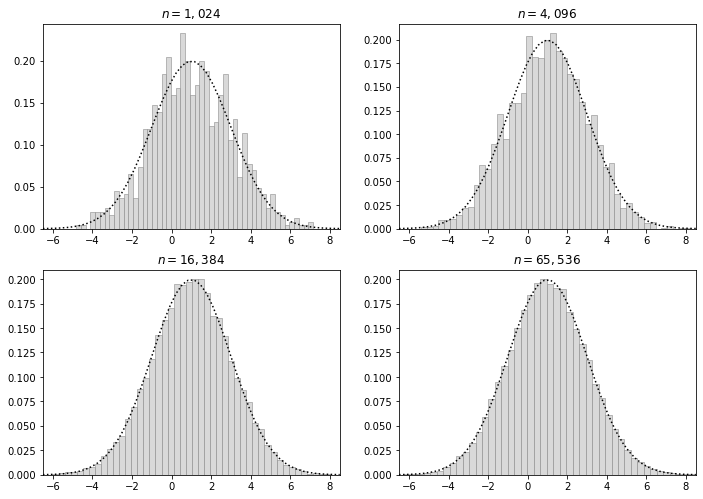

In [2]:
d = norm(loc=1, scale=2)
fig, ax = plt.subplots(2, 2, figsize=(11.7, 8.3))
ax = ax.flatten()
x = np.linspace(-6.5, 8.5)
y = d.pdf(x)
for i, n in enumerate(np.logspace(5, 8, num=4, base=4)):
    ax[i].hist(d.rvs(int(n)), bins=50, density=True,
               fc='0.85', ec='0.5', lw=0.5,)
    ax[i].set_title("$n={:,.0f}$".format(n))
    ax[i].plot(x, y, c='k', ls=':')
    ax[i].set_xlim(-6.5, 8.5)
plt.show()

In [3]:
def define_norm(P10, P90, **kwargs):
    mean = (P90+P10)/2 
    std = (P10-P90)/(norm.ppf(0.9)-norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def define_lognorm(P10, P90, **kwargs):
    std = log(P10 / P90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(P10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))


def define_triang(mini, mode, maxi):
    c = (mode - mini)/(maxi - mini)
    scale = maxi - mini
    return triang(c=c, loc=mini, scale=scale)


def define_beta(P10, P90, mini, maxi):
    loc = mini
    scale = maxi - loc
    f = lambda x, a, b: beta.ppf(x, a, b, loc, scale)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        a, b = curve_fit(f, [0.1, 0.9], [P90, P10])[0]
    return beta(a=a, b=b, loc=loc, scale=scale)

In [38]:
params = {
    'GRV':      define_lognorm(P90=10_000_000, P10=25_000_000),
    'NTG':      define_norm(P90=0.4, P10=0.6),
    'Porosity': define_beta(P90=0.125, P10=0.225, mini=0.05, maxi=0.3),
    'Sw':       define_triang(mini=0.1, maxi=0.6, mode=0.25),
    'FVF':      define_norm(P90=1.1, P10=1.3),
    'RF':       define_norm(P90=0.15, P10=0.25),
}
realisations = pd.DataFrame([], columns=params)

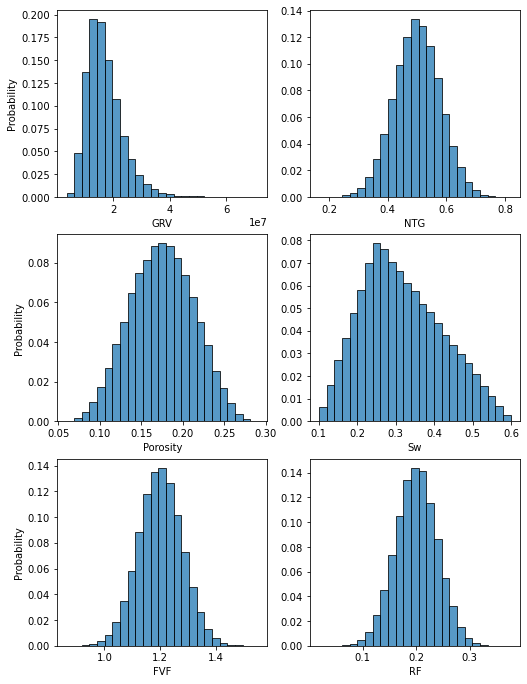

In [62]:
num_samples = 100_000

fig, ax = plt.subplots(nrows=(len(params) // 2 
                              + len(params) % 2),
                       ncols=2,
                       figsize=(8.3, 11.7))
ax = ax.flatten()

for i, (k, v) in enumerate(params.items()):
    x = v.rvs(num_samples)
    realisations[k] = x
    sns.histplot(data=realisations, x=k, ax=ax[i], 
                 stat='probability', bins=25,)
    if i % 2 == 1:
        ax[i].set_ylabel(None)
plt.show()

In [64]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

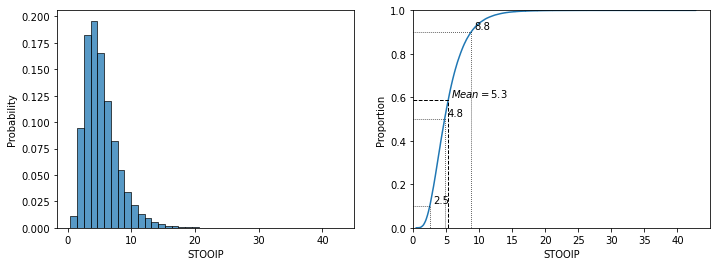

In [65]:
fig, ax = plt.subplots(ncols=2, figsize=(11.7,4))
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
sns.ecdfplot(realisations.STOOIP, ax=ax[1])
ax[1].set_xlim(left=0)
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               c='k', ls=":", lw=0.75)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels')
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(
    realisations.STOOIP,
    mean,
    kind='weak')/100
ax[1].plot([0] + [mean] * 2,
               [Pmean] * 2 + [0],
               c='k', ls="--", lw=1)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels')
plt.show()

In [14]:
realisations.describe()

,GRV,NTG,Porosity,Sw,FVF,RF,STOOIP,Resource
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684924e+07,0.500223,0.175055,0.316407,1.200140,0.200094,5.307239,1.061670
std,6.240341e+06,0.077848,0.037807,0.104781,0.077810,0.038948,2.673165,0.582105
min,3.617075e+06,0.125029,0.061405,0.101523,0.863366,0.032635,0.434364,0.087503
25%,1.241653e+07,0.447575,0.147908,0.236957,1.148087,0.173794,3.418131,0.653561
50%,1.577823e+07,0.500020,0.174845,0.303034,1.200060,0.200112,4.753035,0.934655
75%,2.011375e+07,0.552483,0.202228,0.390504,1.252244,0.226373,6.578032,1.328315
max,8.649403e+07,0.855147,0.293372,0.598517,1.548645,0.369028,33.488824,8.259097


In [23]:
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF,STOOIP,Resource
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684924e+07,0.500223,0.175055,0.316407,1.200140,0.200094,5.307239,1.061670
std,6.240341e+06,0.077848,0.037807,0.104781,0.077810,0.038948,2.673165,0.582105
min,3.617075e+06,0.125029,0.061405,0.101523,0.863366,0.032635,0.434364,0.087503
10%,9.992573e+06,0.400583,0.125235,0.187083,1.100692,0.150263,2.531341,0.469091
50%,1.577823e+07,0.500020,0.174845,0.303034,1.200060,0.200112,4.753035,0.934655
90%,2.497833e+07,0.600436,0.225072,0.467820,1.300290,0.250065,8.739987,1.809216
max,8.649403e+07,0.855147,0.293372,0.598517,1.548645,0.369028,33.488824,8.259097


In [66]:
def formatter(s):
    formats = {
        'Sw':       '{:.1%}',
        'Porosity': '{:.1%}',
        'FVF':      '{:.2}',
        'RF':       '{:.1%}',
        'GRV':      '{:,.1g}',
        'STOOIP':   '{:,.1f}',
        'Resource':  '{:,.1f}',
        'NTG':      '{:.1%}',
    }
    return(s.apply(formats[s.name].format))

def borders(s):
    fmt = 'border-top: 1px solid black; ' \
          + 'font-weight: bold'
    return [fmt for e in s]

summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],) \
    .apply(formatter).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary.style.apply(borders, axis=1, 
                    subset=pd.IndexSlice[['STOOIP', 'Resource'], :])

,Min,P90,P50,P10,Max,Mean
GRV,3e+06,1e+07,2e+07,3e+07,7e+07,2e+07
NTG,16.5%,40.0%,50.0%,60.0%,81.9%,50.0%
Porosity,6.0%,12.5%,17.5%,22.5%,29.1%,17.5%
Sw,10.1%,18.7%,30.4%,46.8%,59.9%,31.6%
FVF,0.86,1.1,1.2,1.3,1.5,1.2
RF,1.9%,15.0%,20.0%,25.0%,37.6%,20.0%
STOOIP,0.5,2.5,4.8,8.8,42.8,5.3
Resource,0.1,0.5,0.9,1.8,8.9,1.1


In [90]:
from IPython.display import Javascript
import urllib.parse

Javascript("const code = Jupyter.notebook.get_cell(1).get_text(); IPython.notebook.kernel.execute(`myvar = '${encodeURI(code)}'`);")
urllib.parse.unquote(myvar)

'# Section\n\n## Subsection\n\nlorem ipsum'

In [88]:
myvar

'#%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum'

In [92]:
import markdown

In [93]:
html = markdown.markdown(myvar)

In [94]:
html

'<h1>%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum</h1>'